In [1]:
import nltk
import numpy as np
import pandas as pd

In [2]:
df=pd.read_csv('IMDB Dataset.csv')

In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.columns

Index(['review', 'sentiment'], dtype='object')

In [5]:
#Remove Tags
from bs4 import BeautifulSoup
soup_text=[]
for text in df['review']:
    soup = BeautifulSoup(text, 'html.parser')
    soup_text.append(soup.getText())

In [6]:
#Tokenize
token_texts=[]
tokenizer = nltk.tokenize.TreebankWordTokenizer()
for text in soup_text:
    tokens = tokenizer.tokenize(text)
    token_texts.append(tokens)

In [7]:
#Remove stop-words
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
no_stopword_text=[]
for text in token_texts:
    no_stopword = [w for w in text if not w in stop_words]
    no_stopword_text.append(no_stopword)

In [8]:
# Remove punctuations, numbers, special characters
no_punct_text=[]
for words in no_stopword_text:
     no_punct_text.append([word for word in words if word.isalpha()])

In [9]:
#Lemmatizing
stemmer = nltk.stem.WordNetLemmatizer()
lemm_text=[]
for text in no_punct_text:
    lemm_text.append(" ".join(stemmer.lemmatize(sent) for sent in text))

In [10]:
final_text=[]
for sent in lemm_text:
    final_text.append(sent.lower())

In [11]:
final_text[2]

'i thought wonderful way spend time hot summer weekend sitting air conditioned theater watching the plot simplistic dialogue witty character likable even well bread suspected serial killer while may disappointed realize match point risk addiction i thought proof woody allen still fully control style many u grown i laughed one woody comedy year dare i say decade while i never impressed scarlet johanson managed tone sexy image jumped right average spirited young may crown jewel career wittier devil wears prada interesting superman great comedy go see friend'

In [12]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
Y = encoder.fit_transform(df['sentiment'])

In [48]:
len(final_text), len(Y)

(50000, 50000)

In [49]:
from collections import Counter
all_text2 = ' '.join(final_text)
# create a list of words
words = all_text2.split()
# Count all the words using Counter Method
count_words = Counter(words)

total_words = len(words)
sorted_words = count_words.most_common(total_words)

In [55]:
vocab_to_int = {w:i for i, (w,c) in enumerate(sorted_words)}

In [56]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

In [57]:
reviews_int = []
for review in final_text:
    r = [vocab_to_int[w] for w in review.split()]
    reviews_int.append(r)

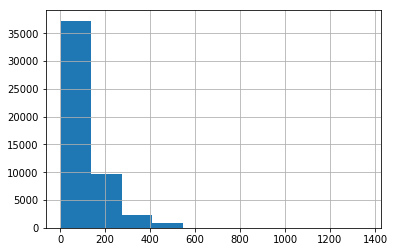

count    50000.000000
mean       116.131160
std         86.389722
min          4.000000
25%         63.000000
50%         87.000000
75%        141.000000
max       1357.000000
dtype: float64

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
reviews_len = [len(x) for x in reviews_int]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

In [60]:
reviews_int = [ reviews_int[i] for i, l in enumerate(reviews_len) if l>0 ]
encoded_labels = [ Y[i] for i, l in enumerate(reviews_len) if l> 0 ]

In [61]:
def pad_features(reviews_int, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_length), dtype = int)
    
    for i, review in enumerate(reviews_int):
        review_len = len(review)
        
        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length:
            new = review[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features

In [63]:
features=pad_features(reviews_int=reviews_int,seq_length=200)

In [67]:
len_feat=len(features)

In [68]:
split_frac = 0.8
train_x = features[0:int(split_frac*len_feat)]
train_y = encoded_labels[0:int(split_frac*len_feat)]
remaining_x = features[int(split_frac*len_feat):]
remaining_y = encoded_labels[int(split_frac*len_feat):]
valid_x = remaining_x[0:int(len(remaining_x)*0.5)]
valid_y = remaining_y[0:int(len(remaining_y)*0.5)]
test_x = remaining_x[int(len(remaining_x)*0.5):]
test_y = remaining_y[int(len(remaining_y)*0.5):]

In [73]:
import torch
from torch.utils.data import DataLoader, TensorDataset
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(np.asarray(train_x)), torch.from_numpy(np.asarray(train_y)))
valid_data = TensorDataset(torch.from_numpy(np.asarray(valid_x)), torch.from_numpy(np.asarray(valid_y)))
test_data = TensorDataset(torch.from_numpy(np.asarray(test_x)), torch.from_numpy(np.asarray(test_y)))
# dataloaders
batch_size = 50
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [74]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 200])
Sample input: 
 tensor([[    0,     0,     0,  ...,  5096, 25172,    29],
        [ 1557,     1,   318,  ...,  1265,    15,     3],
        [    0,     0,     0,  ...,    50,  1153,   138],
        ...,
        [    0,     0,     0,  ...,    62,    72,     2],
        [    0,     0,     0,  ...,   666, 31108,   509],
        [    0,     0,     0,  ...,    53,  1316,    96]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
        1, 1])


In [96]:
import torch.nn as nn

class SentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [97]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2
net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)


SentimentLSTM(
  (embedding): Embedding(90649, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [100]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)


# training params

epochs = 4 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip=5 # gradient clipping

train_on_gpu = torch.cuda.is_available()

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        inputs = inputs.type(torch.LongTensor)
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                inputs = inputs.type(torch.LongTensor)
                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/4... Step: 100... Loss: 0.818803... Val Loss: 0.581551
Epoch: 1/4... Step: 200... Loss: 0.660478... Val Loss: 0.677966
Epoch: 1/4... Step: 300... Loss: 0.473516... Val Loss: 0.522080
Epoch: 1/4... Step: 400... Loss: 0.370340... Val Loss: 0.509130
Epoch: 1/4... Step: 500... Loss: 0.391925... Val Loss: 0.446131
Epoch: 1/4... Step: 600... Loss: 0.424984... Val Loss: 0.457974
Epoch: 1/4... Step: 700... Loss: 0.496538... Val Loss: 0.430185
Epoch: 1/4... Step: 800... Loss: 0.387720... Val Loss: 0.390607
Epoch: 2/4... Step: 900... Loss: 0.266648... Val Loss: 0.365274
Epoch: 2/4... Step: 1000... Loss: 0.473791... Val Loss: 0.368675
Epoch: 2/4... Step: 1100... Loss: 0.330498... Val Loss: 0.361231
Epoch: 2/4... Step: 1200... Loss: 0.293538... Val Loss: 0.352406
Epoch: 2/4... Step: 1300... Loss: 0.338832... Val Loss: 0.333668
Epoch: 2/4... Step: 1400... Loss: 0.220467... Val Loss: 0.349148
Epoch: 2/4... Step: 1500... Loss: 0.264746... Val Loss: 0.329365
Epoch: 2/4... Step: 1600... Loss: 

In [101]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    inputs = inputs.type(torch.LongTensor)
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.406
Test accuracy: 0.859


In [104]:
torch.save(net, 'entire_model.pth')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type SentimentLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [107]:

def tokenize_review(test_review):
    #############
    test_review=BeautifulSoup(test_review, 'html.parser').getText()
    test_review=tokenizer.tokenize(test_review)
    test_review=[w for w in test_review if not w in stop_words]
    test_review=[word for word in test_review if word.isalpha()]
    test_review=" ".join(stemmer.lemmatize(sent) for sent in test_review)
    test_review = test_review.lower() # lowercase
    ############
    
    # get rid of punctuation
    #test_text = ''.join([c for c in test_review if c not in punctuation])

    # splitting by spaces
    test_words = test_review.split(" ")
    # tokens
    test_ints = []
    test_ints.append([vocab_to_int[word] for word in test_words])

    return test_ints



def predict(net, test_review, sequence_length=200):
    
    net.eval()
    
    # tokenize review
    test_ints = tokenize_review(test_review)
    
    # pad tokenized sequence
    seq_length=sequence_length
    features = pad_features(test_ints, seq_length)
    
    # convert to tensor to pass into your model
    feature_tensor = torch.from_numpy(features)
    
    batch_size = feature_tensor.size(0)
    
    # initialize hidden state
    h = net.init_hidden(batch_size)
    
    if(train_on_gpu):
        feature_tensor = feature_tensor.cuda()
    
    # get the output from the model
    output, h = net(feature_tensor, h)
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze()) 
    # printing output value, before rounding
   # print('Prediction value, pre-rounding: {:.6f}'.format(output.item()))
    
    # print custom response
    if(pred.item()==1):
        print("Positive review detected!")
    else:
        print("Negative review detected.")
        
        



In [ ]:
#model_new = torch.load('entire_model.pth')

In [109]:
seq_length=200      
test_review_neg=input('Enter your review here: ')     
predict(net, test_review_neg, seq_length)

Enter your review here:  the movie was bad. Did not like it.


Negative review detected.
